Aviso: cosseno não validado!


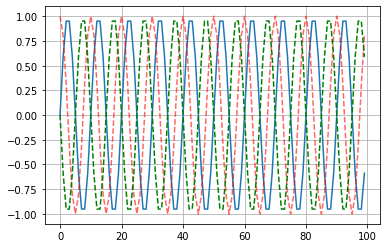

In [1]:
from metodos.geraSenoide import geraSenoide
import seaborn as sns

N = int(1e3) 
f0 = 100
fs = 1000
x = geraSenoide(amplitude=1, N=N, f0 = f0, fs=fs)
y = geraSenoide(amplitude=1, N=N, f0 = f0, fs=fs, cosseno=1)
z = geraSenoide(amplitude=1, N=N, f0 = f0, fs=fs, theta0=3.14)
p = sns.lineplot(data = x[0:100])
p = sns.lineplot(data = y[0:100], color = 'red', linestyle = '--', alpha= 0.6)
p = sns.lineplot(data = z[0:100], color = 'green', linestyle = '--')
p.grid(True)